# Trend analysis with bootstrap resampling

Python / Numpy implementation of the trend analysis presented in [Gardiner et al., 2008][1]

The following model is used to fit the annual trend (drift) + intra-annual variability (i.e., fourier series tuncated at $n$ degrees):

$$ F(t, p, \alpha, \mathrm{{\mathbf \beta}}) = p + \alpha t + \left[\beta_1 \cos(\frac{\pi t}{L}) + \beta_2 \sin(\frac{\pi t}{L}) + \beta_3 \cos(\frac{2 \pi t}{L}) + \beta_4 \sin(\frac{2 \pi t}{L}) + \cdots +  \beta_{2n-1} \cos(\frac{n \pi t}{L}) + \beta_{2n} \sin(\frac{n \pi t}{L}) \right]$$

where $p$ is the intercept, $\alpha$ is the trend (slope), $\mathrm{{\mathbf \beta}}$ are the truncated fourier series parameters, and $L$ is the half-period (= 0.5 if $t$ is in years).

Model parameters are estimated using the weighted linear least squares method. Bootstrap resampling can be used to evaluate the confidence intervals on the parameter estimates (more robust in case of non-normally distributed random effects in the data).

Author: B. Bovy | GIRPAS, ULg

[1]: http://dx.doi.org/10.5194/acp-8-6719-2008

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')

## Implementation

In [2]:
def fourier_basis(x, degree, half_period):
    """Returns a 2-d array of fourier basis."""
    A = np.ones((x.size, 2 * degree + 1))
    
    for d in range(1, degree + 1):
        A[:, 2*d-1] = np.cos(d * np.pi * x / half_period)
        A[:, 2*d] = np.sin(d * np.pi * x / half_period)
    
    return A


def fit_driftfourier(x, data, weights, degree, half_period=0.5):
    """
    Fit y = f(x - x.min()) to data where f is given by
    fourier series + drift.
    
    Parameters
    ----------
    x : 1-d array
        x-coordinates
    data : 1-d array
        data values
    weights : 1-d array
        weights (>=0)
    degree : int
        degree of fourier series
    half_period : float
        half period
    
    Returns
    -------
    intercept : float
        intercept at x.min()
    slope : float
        slope (drift) for the normalized data
        (x - x.min())
    pfourier : 1-d array
        Fourier series parameters for the
        normalized data
    f_drift : callable
        Can be used to calculate the drift
        given any (non-normalized) x
    f_fourier : callable
        Can be used to calculate fourier series
    f_driftfourier : callable
        Can be used to calculate drift + fourier
    residual_std : float
        estimated standard deviation of residuals
    A : 2-d array
        matrix of "coefficients"
    
    """
    xmin = x.min()
    xnorm = x - xmin
    
    # coefficient matrix
    A = np.ones((x.size, 2 * degree + 2))
    A[:, 1] = xnorm
    A[:, 2:] = fourier_basis(xnorm, degree, half_period)[:, 1:]
    
    # linear weighted least squares
    results = np.linalg.lstsq(A * weights[:, np.newaxis],
                              data * weights)
    
    params = results[0]
    intercept = params[0]
    slope = params[1]
    pfourier = params[2:]
    
    f_drift = lambda t: slope * (t - xmin) + intercept
    f_fourier = lambda t: np.sum(fourier_basis(t - xmin, degree,
                                               half_period)[:, 1:]
                                 * pfourier[np.newaxis, :],
                                 axis=1) + intercept
    f_driftfourier = lambda t: f_drift(t) + f_fourier(t) - intercept
    
    residual_std = np.sqrt(results[1][0] / (x.size - 2 * degree + 2)) 
    
    return (intercept, slope, pfourier,
            f_drift, f_fourier, f_driftfourier,
            residual_std, A)


def cf_driftfourier(x, data, weights, degree,
                    half_period=0.5, nboot=5000,
                    percentiles=(2.5, 50., 97.5)):
    """
    Calculate confidence intervals for the fitted
    parameters from fourier series + drift modelling,
    using bootstrap resampling.
    
    Parameters
    ----------
    nboot : int
        number of bootstrap replicates
    percentiles : sequence of floats
        percentiles of parameter estimate
        distributions to return 
    
    Returns
    -------
    perc : dict
        percentiles for each parameter
        distribution.
    boot_intercept : 1-d array
        intercept estimates from bootstrapped
        datasets.
    boot_slope : 1-d array
        slope estimates.
    boot_pfourier : 2-d array
        fourier parameters estimates.
    
    See Also
    --------
    :func:`fit_driftfourier`
    
    """
    # first fit without bootstrapping
    results = fit_driftfourier(x, data, weights,
                               degree, half_period)
    f_driftfourier = results[5]
    A = results[7]
    model = f_driftfourier(x)
    residuals = data - model
    
    # generate bootstrap resamples of residuals
    # and new datasets from these resamples
    resample_residuals = np.random.choice(
        residuals, size=(x.size, nboot), replace=True
    )
    boot_dataset = model[:, np.newaxis] + resample_residuals
    
    # fit all bootstrap datasets at once
    results_boot = np.linalg.lstsq(A * weights[:, np.newaxis],
                                   boot_dataset * weights[:, np.newaxis])
    
    params_boot = results_boot[0]
    
    # compute percentiles
    perc_boot = np.column_stack(
        np.percentile(params_boot, percentiles, axis=1)
    )
    
    perc = {'intercept' : perc_boot[0],
            'slope' : perc_boot[1],
            'pfourier' : perc_boot[2:]}
    
    intercept = params_boot[0]
    slope = params_boot[1]
    pfourier = params_boot[2:]
    
    return perc, intercept, slope, pfourier
    

In [3]:
def get_slope_percent(slope, intercept):
    """
    Express `slope` as percentage, taking
    the `intercept` value as reference (100%).
    """
    return slope / intercept * 100.

## CCL4 NY4 data

Import the data from CSV

In [4]:
ccl4_nya = pd.read_csv('data/CCL4_NYA.csv', header=None,
                       names=['time', 'col_density'])

**Fit trend only (no fourier parameters added to the model), without bootstrapping**. Also express trend as percentage.

In [5]:
x = ccl4_nya['time'].values
y = ccl4_nya['col_density'].values
w = np.ones_like(x)
fourier_degree = 0   # fit trend only

res = fit_driftfourier(x, y, w, fourier_degree)
intercept, slope, pfourier, residuals_std = res[0:3] + (res[6],)
f_drift, f_fourier, f_driftfourier = res[3:6]
slope_percent = get_slope_percent(slope, intercept)

Print the results

In [6]:
print("fitted trend: {:.3E} molec./cm2/yr | {:.3f} %/yr".format(slope, slope_percent))
print("fitted intercept at xmin: {:.3E} molec./cm2".format(intercept))
print("fitted fourier parameters: {}".format(pfourier))
print("std of residuals: {:.3E} molec./cm2".format(residuals_std))

fitted trend: -2.018E+13 molec./cm2/yr | -1.083 %/yr
fitted intercept at xmin: 1.863E+15 molec./cm2
fitted fourier parameters: []
std of residuals: 3.186E+14 molec./cm2


Plot data + fitted line

/home/python/miniconda3/envs/main_py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


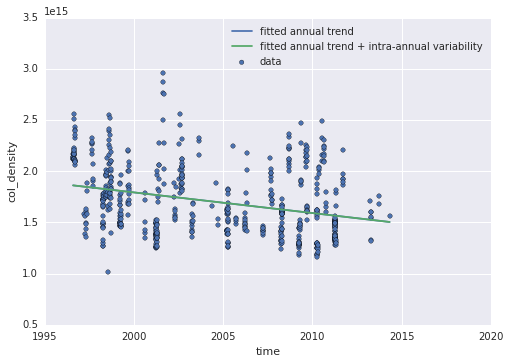

In [7]:
ccl4_nya.plot(x='time', y='col_density', kind='scatter', label='data')
plt.plot(x, f_drift(x), label='fitted annual trend')
plt.plot(x, f_driftfourier(x),
         label='fitted annual trend + intra-annual variability')
plt.legend()

**Fit trend only, with bootstrap resampling**. Compute 2.5% and 97.5% percentiles (i.e., the 95% interval) for each fitted parameter. Compute also the percentiles for trend in %.

In [8]:
ci95_percentiles = (2.5, 97.5)

cf, boot_intercept, boot_slope, boot_pfourier = cf_driftfourier(
    x, y, w, fourier_degree, nboot=20000,
    percentiles=ci95_percentiles
)

boot_slope_percent = get_slope_percent(boot_slope, boot_intercept)
cf['slope_percent'] = np.percentile(boot_slope_percent, ci95_percentiles)

Print the results

In [9]:
print("95% CI for trend: ({:.3E}, {:.3E}) molec./cm2/yr".format(*cf['slope']))
print("95% CI for trend: ({:.3f}, {:.3f}) %/yr".format(*cf['slope_percent']))
print("95% CI for intercept: ({:.3E}, {:.3E}) molec./cm2".format(*cf['intercept']))
print("percentiles for fourier parameters: {}".format(cf['pfourier']))

95% CI for trend: (-2.510E+13, -1.526E+13) molec./cm2/yr
95% CI for trend: (-1.320, -0.836) %/yr
95% CI for intercept: (1.817E+15, 1.909E+15) molec./cm2
percentiles for fourier parameters: []


Histograms of the distributions of the annual trend and intercept estimates obtained from bootstrap resampling.

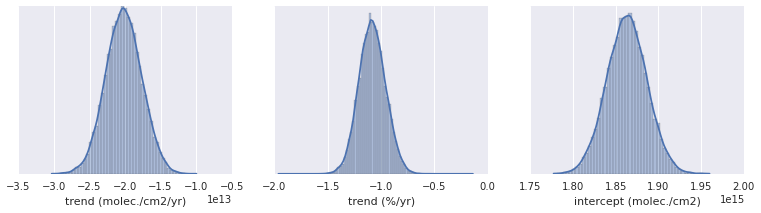

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(13, 3))

def plot_bootdist(v, ax, label):
    sns.distributions.distplot(v, ax=ax)
    plt.setp(ax, xlabel=label, yticks=[])

plot_bootdist(boot_slope, axes[0], 'trend (molec./cm2/yr)')
plot_bootdist(boot_slope_percent, axes[1], 'trend (%/yr)')
plot_bootdist(boot_intercept, axes[2], 'intercept (molec./cm2)')